# Vehicle Detection Project

Here you will find a vehicle detection algorithm that uses a Linear SVM classifier and a sliding window technique to detect vehicles in a scene in a translation invariant way.

Here we read in images used for training the classifier.

In [25]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from skimage.feature import hog


car_image_dirs = ["training"]
car_image_locations = glob.glob("./training/vehicles/**/*.png", recursive=True)
non_car_image_locations = glob.glob("./training/non-vehicles/**/*.png",recursive=True)

def read_image(filename):
    return mpimg.imread(filename)
    
car_images = [read_image(image) for image in car_image_locations]
non_car_images = [read_image(image) for image in non_car_image_locations]

Here we define a feature vector that will be used by the classifier.  It contains three components.
* A downsampled version of the image, broken into color channels, and converted to a 1D vector
* A histogram of color values, broken down by color channel, and then histogrammed into 32 bins
* A histogram of gradient feature

In [26]:
def spatial_color_bin_feature(img,size=(32,32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1,color2,color3))

def color_hist_feature(img, nbins=32):
    chan1 = np.histogram(img[:,:,0], bins=nbins)
    chan2 = np.histogram(img[:,:,1], bins=nbins)
    chan3 = np.histogram(img[:,:,2], bins=nbins)
    hist_features = np.concatenate((chan1[0], chan2[0], chan3[0]))
    return hist_features

def hog_feature(img, orient=9, pix_per_cell=8, cell_per_block=2):
    hog_features = []
    for channel in range(img.shape[2]):
      hog_features.append(hog(img[:,:,channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=False, feature_vector=True))
    return np.ravel(hog_features)

def feature_vector(img):
    converted_color_space = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    resized_img = cv2.resize(converted_color_space, (64, 64))
    return np.concatenate( (color_hist_feature(resized_img), hog_feature(resized_img), spatial_color_bin_feature(resized_img)))



Create feature vectors from our training images.

In [27]:
car_features = [ feature_vector(img) for img in car_images]
non_car_features = [feature_vector(img) for img in non_car_images]

Prepare data by scaling and creating labels.

In [28]:
from sklearn.preprocessing import StandardScaler


X = np.vstack([car_features,non_car_features]).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(non_car_features))))


Train the classifier and determine it's accuracy.

In [29]:
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

svc = LinearSVC()
svc.fit(X_train, y_train)
print("shape: X_train: ", X_train.shape)
print("accuracy:", sum( svc.predict(X_test) == y_test ) / len(y_test))


shape: X_train:  (14208, 8460)
accuracy: 0.989583333333
Test Accuracy of SVC =  0.9896


Create a function that can generate multiple overlapping windows from an input image.  The windows will be used later to determine the presence or absence of a vehicle.

In [71]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[400, 600], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


def generate_windows(img):
    window_size_scales = [0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 2.5, 3.0]
    window_sizes = [ (int(i * 64.0), int(i * 64.0)) for i in window_size_scales]
    y_start_stops = [[400,450],[400,450],[400,500],[400,500],[400,550],[350,600],[350,600],[350,600]]
    windows = []
    for size, y_start_stop in zip(window_sizes,y_start_stops):
        #print("using {} and {}".format(size, y_start_stop))
        windows += slide_window(img, xy_window=size, y_start_stop=y_start_stop,xy_overlap=(0.66,0.66))
    return windows

Create a function that can execute the classifier trained above for each window supplied.

In [72]:
def search_windows(img):
    windows = generate_windows(img)
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = feature_vector(test_img)
        #5) Scale extracted features to be fed to classifier
        test_features = X_scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = svc.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    #print("detected {} out of {}".format(len(on_windows),len(windows)))
    return on_windows

To avoid false positives, create a function that can generate a count of detections per region across all window sizes.  The detection counts then can be thresholded to avoid spurious detections.

In [73]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label
from collections import deque

def scale_jpg(img):
    return img.astype(np.float32)/255

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


Construct a complete pipeline that can generate windows of detected vehicles, remove false positives, and draw bounding boxes of detections.

In [74]:

def pipeline(img,previous_heatmaps=deque(),frame_count=60,threshold=55):
  cp = np.copy(img)
  scaled = scale_jpg(cp)
  boxes = search_windows(scaled)
  heat = np.zeros_like(img[:,:,0]).astype(np.float)
  heat = add_heat(heat,boxes)
  heatmap = np.clip(heat, 0, 255)
  if len(previous_heatmaps) > frame_count:
    previous_heatmaps.popleft()
  
  previous_heatmaps.append(heatmap)

  summed_heatmap = np.zeros_like(heatmap)
  for previous_heatmap in previous_heatmaps:
    summed_heatmap = np.add(previous_heatmap, summed_heatmap)
  heat = apply_threshold(summed_heatmap,threshold)
  labels = label(heat)
  return draw_labeled_bboxes(img, labels)
  #return heat

Draw some example detections using the supplied test images.

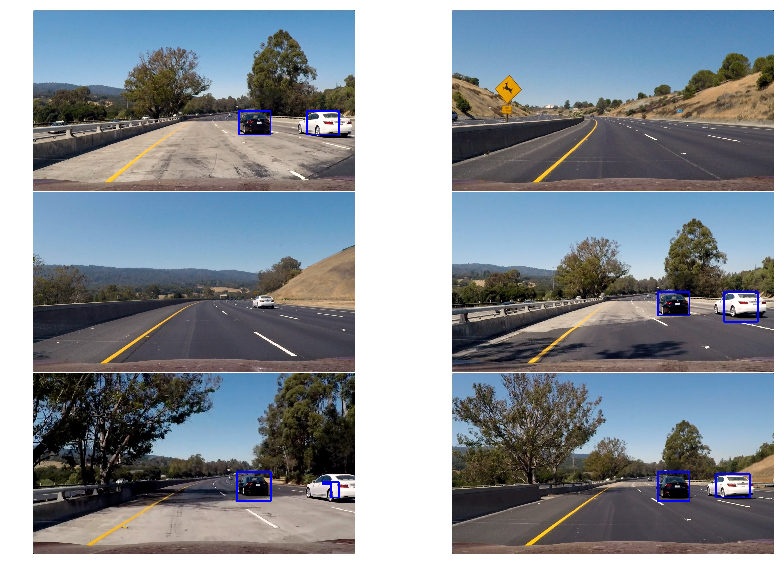

In [75]:
%matplotlib inline
test_images = glob.glob('./test_images/*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(15,10))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, image in enumerate(test_images):
    axs[i].imshow(pipeline(mpimg.imread(image),previous_heatmaps=deque(), threshold=5))
    axs[i].axis('off')
plt.savefig('examples/test_image_results.jpg')

Apply the pipeline to the project video.  We also create a deque to store multiple frames of heatmaps so that we can threshold across multiple frames.

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
    
    
previous_frames = deque([])
def multiframe_pipeline(img):
    return pipeline(img, previous_frames)
video_output = 'test_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(multiframe_pipeline)
%time clip.write_videofile(video_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="./{0}" type="video/mp4">
</video>
""".format(video_output))